In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras_tuner

from sklearn.preprocessing import StandardScaler, MinMaxScaler

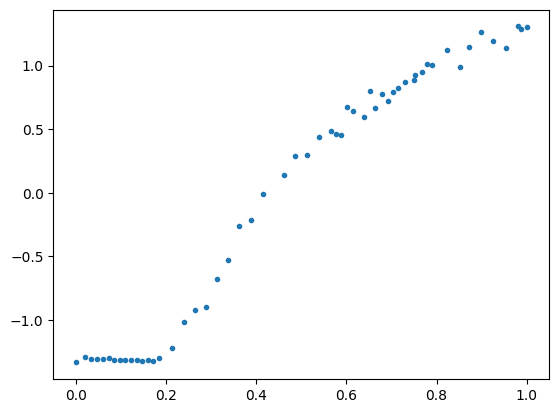

In [2]:
# Load data from .npy files
x = np.load("../data_out/p3inn/core2/x_data.npy")
y = np.load("../data_out/p3inn/core2/y_data.npy")

# Reshape x if it's 1D to ensure it's a column vector
if x.ndim == 1:
    x = x.reshape(-1, 1)

x_train = x.copy()
y_train = y.copy()

# Normalize data
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

del scaler_x
del scaler_y

plt.plot(x_train, y_train, ".")
plt.show()

In [3]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp: keras_tuner.HyperParameters):
        model = keras.Sequential(
            [
                keras.Input(shape=(1,)),
                # keras.layers.BatchNormalization(),
                keras.layers.Dense(hp.Int("n_hidden1", 16, 256, 16), activation="tanh"),
                
            ]
        )
        if hp.Boolean("extra_hidden", False):
            model.add(
                keras.layers.Dense(hp.Int("n_hidden2", 16, 256, 16), activation="tanh")
            )
        model.add(
            keras.layers.Dense(1)
        )

        # good adam values: 0.06 (min: 0.02, max: 0.1)
        initial_learning_rate = hp.Float(
            "initial_learning_rate", min_value=0.005, max_value=0.1, sampling="log"
        )
        scheduler = hp.Choice("scheduler", ["cosine", "expo"])
        if scheduler == "cosine":
            learning_rate = keras.optimizers.schedules.CosineDecayRestarts(
                initial_learning_rate,
                first_decay_steps=hp.Choice("first_decay_steps", [30, 100]),
            )
        elif scheduler == "expo":
            learning_rate = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=hp.Choice("decay_steps", [10, 60]),
                decay_rate=hp.Choice("decay_rate", [0.98, 0.8]),
                staircase=True,
            )
        else:
            raise ValueError(f"Unknown schedule: {scheduler}")
        # learning_rate = initial_learning_rate

        optimizer_choice = hp.Choice("optimizer", ["adamw", "adam"])
        if optimizer_choice == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_choice == "adamw":
            optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_choice}")

        model.compile(optimizer=optimizer, loss="mse")

        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int('batch_size', min_value=8, max_value=64, step=8),
            **kwargs,
        )

# tuner = keras_tuner.RandomSearch(
#     MyHyperModel(),
#     objective="loss",
#     max_trials=100,  # Number of hyperparameter combinations to try
#     executions_per_trial=1,  # Increase if you want to average multiple runs per trial
#     directory="../data_out/hypertuning/p3inn_core2",  # Where to save tuning results
#     project_name="relu:lr_optimizer_schedule",
#     # overwrite=True,
# )
tuner = keras_tuner.Hyperband(
    MyHyperModel(),
    objective="loss",
    max_epochs=500,
    factor=3,
    hyperband_iterations=3,
    executions_per_trial=4,  # Increase if you want to average multiple runs per trial
    directory="../data_out/hypertuning/p3inn_core2",  # Where to save tuning results
    project_name="hyperband#tanh:lr_optimizer_schedule",
    # overwrite=True,
)
print(tuner.remaining_trials)
tuner.search_space_summary()

Reloading Tuner from ../data_out/hypertuning/p3inn_core2/hyperband#tanh:lr_optimizer_schedule/tuner0.json
None
Search space summary
Default search space size: 10
n_hidden1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
extra_hidden (Boolean)
{'default': False, 'conditions': []}
initial_learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.005, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
scheduler (Choice)
{'default': 'cosine', 'conditions': [], 'values': ['cosine', 'expo'], 'ordered': False}
first_decay_steps (Choice)
{'default': 30, 'conditions': [], 'values': [30, 100], 'ordered': True}
optimizer (Choice)
{'default': 'adamw', 'conditions': [], 'values': ['adamw', 'adam'], 'ordered': False}
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
decay_steps (Choice)
{'default': 10, 'conditions': [], 'values': [10, 60], 'ordered': Tru

In [4]:
# 0.088826	16	adamw	0	0.007814

# best loss so far: 0.005 (with adam, lr=0.06)
# but I need at least 0.001
# so min_delta of     0.0001 seems good
EARLY_STOPPING_PARAMS = dict(monitor="loss", patience=150, min_delta=0.0001)
TRAINING_PARAMS = dict(
    # epochs=1000,
    validation_split=0.2,
)

In [ ]:
tuner.search(
    x_train,
    y_train,
    **TRAINING_PARAMS,
    callbacks=[keras.callbacks.EarlyStopping(**EARLY_STOPPING_PARAMS)],
)

best_model = tuner.get_best_models(num_models=1)[0]# 575 trials before bed (best loss=0.00193)
!say "Done"

In [ ]:
for good_hp in tuner.get_best_hyperparameters(num_trials=10):
    print(good_hp.values)

In [ ]:
print(tuner.get_best_hyperparameters(1)[0].values)

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

In [ ]:
# Train the best model
history = best_model.fit(
    x_train,
    y_train,
    **TRAINING_PARAMS,
    callbacks=[keras.callbacks.EarlyStopping(**EARLY_STOPPING_PARAMS)],
)

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.semilogy(history.history["loss"], label="Training Loss")
ax1.semilogy(history.history["val_loss"], label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()


# Plot learned function and data
x_plot = np.linspace(x_train.min(), x_train.max(), 200).reshape(
    -1, 1
)  # 200 points for smooth curve

# x_plot_scaled = scaler_x.transform(x_plot)  # Scale the x values for prediction
# y_pred_scaled = best_model.predict(x_plot_scaled)
# y_pred = scaler_y.inverse_transform(
#     y_pred_scaled
# ).flatten()  # Inverse scale predictions

x_plot_scaled = x_plot
y_pred = best_model.predict(x_plot_scaled)


ax2.scatter(x_train, y_train, label="Data")
ax2.plot(x_plot, y_pred, color="red", label="Learned Function")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px


results = []
for trial in tuner.oracle.get_best_trials(100):
    hps = trial.hyperparameters.values
    hps['score'] = trial.score
    results.append(hps)
df = pd.DataFrame(results).sort_values(by="score", ignore_index=True)

categories = ["optimizer", "scheduler"]
for cat in categories:
    df[f"#{cat}"] = df[cat].astype("category").cat.codes

# Reorder columns to place 'score' last and categories before it
other_cols = [col for col in df.columns if col not in categories and col != 'score' and col not in [f"#{cat}" for cat in categories]]
ordered_cols = other_cols + categories + [f"#{cat}" for cat in categories] + ['score']
df = df[ordered_cols]

# df = df.query("optimizer == 'adam'").drop("#optimizer", axis=1).reset_index(drop=True)
df = df.query("scheduler == 'cosine'").drop("#scheduler", axis=1).reset_index(drop=True)
display(df)

fig = px.parallel_coordinates(df, color="score")
fig.show()